# XGBoost with dart Booster

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pickle
import time
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

# Metrics
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve, confusion_matrix

# Load Data

In [2]:
# Load pickled data
df = pd.read_pickle("data/yelp_df_final.pkl")

# Split data
train_df = df[df["dataset"] == "train"]
valid_df = df[df["dataset"] == "val"].reset_index(drop = True)
test_df  = df[df["dataset"] == "test"].reset_index(drop = True)

In [3]:
# Parameters excluded from predictions
exclude = ["review_id", 
           "business_id", 
           "user_id", 
           "label", 
           "date", 
           "categories", 
           "is_open",
           "postal_code", 
           "dataset"]

# Predictors
predictors = list(train_df.columns)
for col in exclude:   
    predictors.remove(col)

# Label
outcome = "label"

In [4]:
# Train features and labels
X_train = np.array(train_df[predictors])
y_train = np.array(train_df[outcome])

# Validation features and labels
X_valid = np.array(valid_df[predictors])
y_valid = np.array(valid_df[outcome])

# Test features and labels
X_test  = np.array(test_df[predictors])
y_test  = np.array(test_df[outcome])

In [5]:
# Save XGBoost data types 
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)
dtest  = xgb.DMatrix(X_test,  label = y_test)

# Set Parameters

In [6]:
# Hyperparameters for model
param = {'max_depth': 4,
         'eta': 1.0,
         'min_child_weight': 1}

# Base estimator
param['booster'] = 'dart'

# Learning task and corresponding learning objective
param['objective'] = 'binary:logistic'

# Evaluation metrics for validation data 
# (wrong cases) / (all cases)
param['eval_metric'] = 'error' 

# Specify validation set to watch performance
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

# Number of rounds for boosting
num_round = 200

# Validation error needs to decrease at least every early_stopping_rounds 
early_stopping_rounds = 2

# Training

In [7]:
# Start timer 
start_time = time.time()

# Train model
bst = xgb.train(params = param, 
                dtrain = dtrain, 
                num_boost_round = num_round, 
                evals = evallist,
                early_stopping_rounds = early_stopping_rounds)

# End timer
end_time = time.time()
print("Time for training: {:.2f} seconds".format(end_time - start_time))
print("Best iteration         {}".format(bst.best_iteration))

try:
    print("Best validation error: {}".format(bst.best_score))
    print("Best ntree limit:      {}".format(bst.best_ntree_limit))
except:
    print("Early stopping did not occur")

[0]	eval-error:0.25755	train-error:0.262223
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 2 rounds.
[1]	eval-error:0.253899	train-error:0.260363
[2]	eval-error:0.24831	train-error:0.255315
[3]	eval-error:0.245958	train-error:0.254398
[4]	eval-error:0.245075	train-error:0.253717
[5]	eval-error:0.24484	train-error:0.252778
[6]	eval-error:0.24369	train-error:0.252293
[7]	eval-error:0.243432	train-error:0.251597
[8]	eval-error:0.241651	train-error:0.250162
[9]	eval-error:0.241638	train-error:0.249891
[10]	eval-error:0.241361	train-error:0.249628
[11]	eval-error:0.241103	train-error:0.249409
[12]	eval-error:0.241003	train-error:0.24935
[13]	eval-error:0.240836	train-error:0.249243
[14]	eval-error:0.240635	train-error:0.24914
[15]	eval-error:0.240692	train-error:0.248984
[16]	eval-error:0.240527	train-error:0.248755
[17]	eval-error:0.256964	train-error:0.257863
[18]	eval-error:0.240149	train-error:0.248

In [8]:
# Save model
bst.save_model("results/xgb_dart.model")

## Validation Set Performance

In [9]:
# Predict using best validation set performer
prob_valid = bst.predict(dvalid, ntree_limit = bst.best_ntree_limit)
pred_valid = [0 if x < 0.5 else 1 for x in prob_valid]

In [10]:
# Prediction metrics
print("Accuracy:  {:.3f}%".format(accuracy_score(y_valid, pred_valid)))
print("Precision: {:.3f}%".format(precision_score(y_valid, pred_valid)))
print("Recall:    {:.3f}%".format(recall_score(y_valid, pred_valid)))
print("F1:        {:.3f}%".format(f1_score(y_valid, pred_valid)))

Accuracy:  0.762%
Precision: 0.789%
Recall:    0.734%
F1:        0.760%


In [11]:
print("Validation Confusion Matrix")
print(confusion_matrix(y_valid, pred_valid))

Validation Confusion Matrix
[[202860  53085]
 [ 72296 199035]]


Text(0.5,1,'Validation Set Receiver Operator Characteristic')

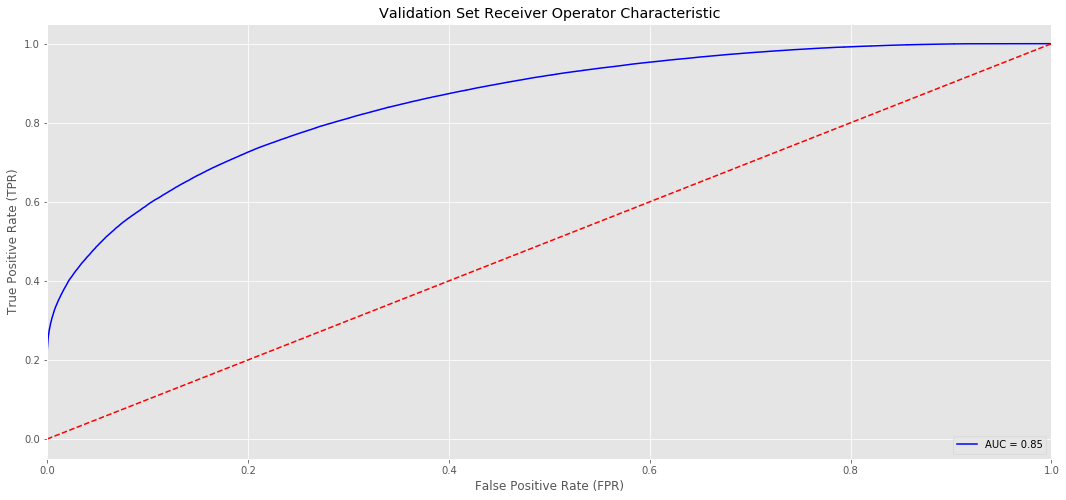

In [12]:
# Validation set AUROC curve
fpr, tpr, threshold = roc_curve(y_valid, prob_valid)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(18, 8))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.xlim(0,1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Validation Set Receiver Operator Characteristic")

# Test Set Performance

In [13]:
# Predict using best validation set performer
prob_test = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)
pred_test = [0 if x < 0.5 else 1 for x in prob_test]

In [14]:
# Prediction metrics
print("Accuracy:  {:.3f}%".format(accuracy_score(y_test, pred_test)))
print("Precision: {:.3f}%".format(precision_score(y_test, pred_test)))
print("Recall:    {:.3f}%".format(recall_score(y_test, pred_test)))
print("F1:        {:.3f}%".format(f1_score(y_test, pred_test)))

Accuracy:  0.766%
Precision: 0.793%
Recall:    0.743%
F1:        0.767%


In [15]:
print("Test Confusion Matrix")
print(confusion_matrix(y_valid, pred_valid))

Test Confusion Matrix
[[202860  53085]
 [ 72296 199035]]


Text(0.5,1,'Test Set Receiver Operator Characteristic')

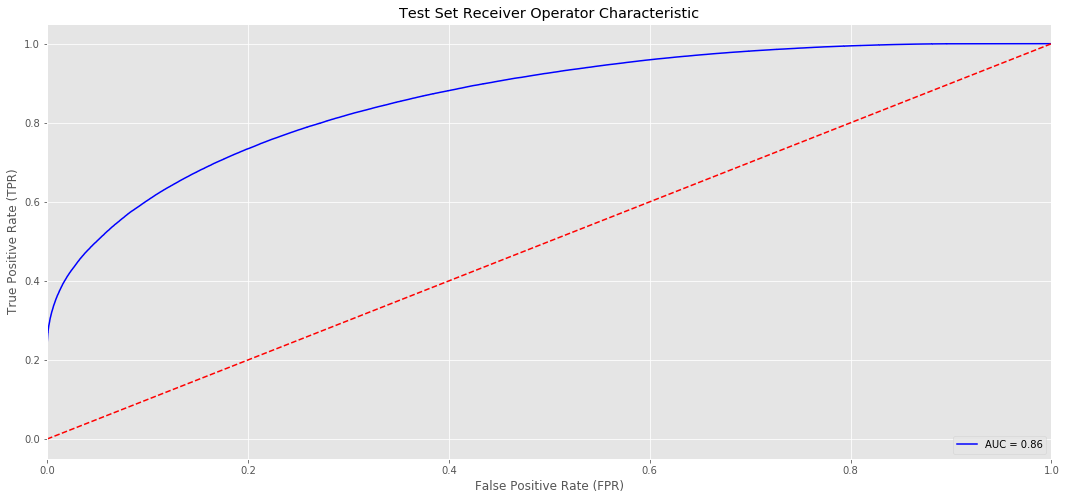

In [16]:
# Validation set AUROC curve
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(18, 8))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0, 1], 'r--')
plt.legend(loc = 'lower right')
plt.xlim(0,1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Test Set Receiver Operator Characteristic")